# 04. Model Training - Drug-Target Interaction Prediction

This notebook trains GNN models for DTI prediction using the preprocessed molecular graphs and protein features.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch

import sys
sys.path.append('../models')
from gnn_models import get_model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set paths
DATA_DIR = Path('../data')
PROCESSED_DATA = DATA_DIR / 'processed'
RAW_DATA = DATA_DIR / 'raw'
MODEL_DIR = Path('../models/checkpoints')
MODEL_DIR.mkdir(exist_ok=True)

Using device: cuda


## 2. Load Preprocessed Data

In [2]:
# Load molecular graphs
with open(PROCESSED_DATA / 'molecular_graphs' / 'davis_graphs.pkl', 'rb') as f:
    davis_mol_graphs = pickle.load(f)

with open(PROCESSED_DATA / 'molecular_graphs' / 'kiba_graphs.pkl', 'rb') as f:
    kiba_mol_graphs = pickle.load(f)

# Load protein features
with open(PROCESSED_DATA / 'protein_features' / 'davis_protein_fixed.pkl', 'rb') as f:
    davis_protein_features = pickle.load(f)

with open(PROCESSED_DATA / 'protein_features' / 'kiba_protein_fixed.pkl', 'rb') as f:
    kiba_protein_features = pickle.load(f)

# Load affinity data
with open(RAW_DATA / 'davis' / 'Y', 'rb') as f:
    davis_Y = pickle.load(f, encoding='latin1')

with open(RAW_DATA / 'kiba' / 'Y', 'rb') as f:
    kiba_Y = pickle.load(f, encoding='latin1')

print(f"Loaded DAVIS: {len(davis_mol_graphs)} drugs, {len(davis_protein_features)} proteins")
print(f"Loaded KIBA: {len(kiba_mol_graphs)} drugs, {len(kiba_protein_features)} proteins")
print(f"DAVIS affinity matrix shape: {davis_Y.shape}")
print(f"KIBA affinity matrix shape: {kiba_Y.shape}")

Loaded DAVIS: 68 drugs, 442 proteins
Loaded KIBA: 2111 drugs, 229 proteins
DAVIS affinity matrix shape: (68, 442)
KIBA affinity matrix shape: (2111, 229)


## 3. Create DTI Dataset

In [3]:
class DTIDataset(Dataset):
    """Drug-Target Interaction dataset"""
    
    def __init__(self, mol_graphs, protein_features, affinity_matrix, threshold=30000):
        self.mol_graphs = mol_graphs
        self.protein_features = protein_features
        self.affinity_matrix = affinity_matrix
        self.threshold = threshold
        
        # Get drug and protein IDs
        self.drug_ids = list(mol_graphs.keys())
        self.protein_ids = list(protein_features.keys())
        
        # Create pairs with known interactions
        self.pairs = []
        self.labels = []
        
        for i, drug_id in enumerate(self.drug_ids):
            for j, protein_id in enumerate(self.protein_ids):
                affinity = affinity_matrix[i, j]
                if affinity < threshold:  # Known interaction
                    self.pairs.append((drug_id, protein_id))
                    # Convert Kd to pKd for better learning
                    pkd = -np.log10(affinity / 1e9)
                    self.labels.append(pkd)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        drug_id, protein_id = self.pairs[idx]
        
        # Get molecular graph
        mol_graph = self.mol_graphs[drug_id]
        
        # Get protein features
        protein_feat = torch.FloatTensor(self.protein_features[protein_id])
        
        # Get label
        label = torch.FloatTensor([self.labels[idx]])
        
        return mol_graph, protein_feat, label

# Create datasets
davis_dataset = DTIDataset(davis_mol_graphs, davis_protein_features, davis_Y)
print(f"DAVIS dataset: {len(davis_dataset)} drug-target pairs")

# Split into train/val/test
train_size = int(0.8 * len(davis_dataset))
val_size = int(0.1 * len(davis_dataset))
test_size = len(davis_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    davis_dataset, [train_size, val_size, test_size]
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

DAVIS dataset: 30056 drug-target pairs
Train: 24044, Val: 3005, Test: 3007


## 4. Create Data Loaders

In [4]:
def collate_fn(batch):
    """Custom collate function for DTI data"""
    graphs, proteins, labels = zip(*batch)
    
    # Batch molecular graphs
    batched_graph = Batch.from_data_list(graphs)
    
    # Stack protein features and labels
    batched_proteins = torch.stack(proteins)
    batched_labels = torch.stack(labels)
    
    return batched_graph, batched_proteins, batched_labels

# Create data loaders
scaler = GradScaler('cuda')
batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True
)

print(f"Created data loaders with batch size {batch_size}")

Created data loaders with batch size 128


## 5. Initialize Models

In [5]:
# Get feature dimensions
sample_graph = next(iter(davis_mol_graphs.values()))
num_node_features = sample_graph.x.shape[1]
protein_feature_dim = next(iter(davis_protein_features.values())).shape[0]

print(f"Node features: {num_node_features}")
print(f"Protein features: {protein_feature_dim}")

# Initialize models
models = {}
model_names = ['gcn', 'gat', 'gin']

for model_name in model_names:
    model = get_model(
        model_name,
        num_features=num_node_features,
        hidden_dim=128,
        num_layers=3,
        dropout=0.2,
        protein_dim=protein_feature_dim
    )
    model = model.to(device)
    models[model_name] = model
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name.upper()} - Total params: {total_params:,}, Trainable: {trainable_params:,}")

Node features: 158
Protein features: 10
GCN - Total params: 129,537, Trainable: 129,537
GAT - Total params: 1,427,713, Trainable: 1,427,713
GIN - Total params: 179,073, Trainable: 179,073


## 6. Training Functions

In [6]:
def train_epoch(model, loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch in tqdm(loader, desc="Training"):
        graphs, proteins, labels = batch

        proteins = proteins.to(device)
        labels = labels.to(device)

        # Explicitly move each graph component
        x = graphs.x.to(device)
        edge_index = graphs.edge_index.to(device)
        batch = graphs.batch.to(device)

        optimizer.zero_grad()
        outputs = model(x, edge_index, batch, proteins)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(labels)
    
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            graphs, proteins, labels = batch
            proteins = proteins.to(device)
            labels = labels.to(device)
            
            # Explicitly move each graph component
            x = graphs.x.to(device)
            edge_index = graphs.edge_index.to(device)
            batch = graphs.batch.to(device)
            
            outputs = model(x, edge_index, batch, proteins)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * len(labels)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    pearson_corr = pearsonr(all_labels, all_preds)[0]
    spearman_corr = spearmanr(all_labels, all_preds)[0]
    
    metrics = {
        'loss': total_loss / len(loader.dataset),
        'mse': mse,
        'mae': mae,
        'rmse': np.sqrt(mse),
        'r2': r2,
        'pearson': pearson_corr,
        'spearman': spearman_corr
    }
    
    return metrics, all_preds, all_labels

## 7. Train Models

In [7]:
# Training hyperparameters
num_epochs = 50
learning_rate = 0.001
criterion = nn.MSELoss()

# Train each model
results = {}

for model_name, model in models.items():
    print(f"\n" + "="*50)
    print(f"Training {model_name.upper()} model")
    print("="*50)
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        # Validate
        val_metrics, _, _ = evaluate(model, val_loader, criterion, device)
        val_loss = val_metrics['loss']
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_DIR / f'{model_name}_best.pt')
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_loss:.4f}")
            print(f"  Val RMSE: {val_metrics['rmse']:.4f}")
            print(f"  Val Pearson: {val_metrics['pearson']:.4f}")
    
    # Load best model and test
    model.load_state_dict(torch.load(MODEL_DIR / f'{model_name}_best.pt'))
    test_metrics, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
    
    results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_metrics': test_metrics,
        'test_preds': test_preds,
        'test_labels': test_labels
    }
    
    print(f"\nTest Results for {model_name.upper()}:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")


Training GCN model


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 95.16it/s]


Epoch 10/50
  Train Loss: 4.1894
  Val Loss: 2.3734
  Val RMSE: 1.5406
  Val Pearson: 0.2161


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 99.79it/s] 


Epoch 20/50
  Train Loss: 3.4771
  Val Loss: 1.7923
  Val RMSE: 1.3388
  Val Pearson: 0.3407


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 90.88it/s]


Epoch 30/50
  Train Loss: 2.1359
  Val Loss: 1.0147
  Val RMSE: 1.0073
  Val Pearson: 0.4673


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 89.85it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]


Epoch 40/50
  Train Loss: 1.4679
  Val Loss: 0.8949
  Val RMSE: 0.9460
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 91.60it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 81.13it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 101.41it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input

Epoch 50/50
  Train Loss: 1.1191
  Val Loss: 0.8723
  Val RMSE: 0.9340
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 94.32it/s]



Test Results for GCN:
  loss: 0.8075
  mse: 0.8075
  mae: 0.6367
  rmse: 0.8986
  r2: 0.0241
  pearson: 0.3407
  spearman: 0.3427

Training GAT model


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 86.53it/s]


Epoch 10/50
  Train Loss: 4.2062
  Val Loss: 4.1287
  Val RMSE: 2.0319
  Val Pearson: 0.1717


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 77.18it/s]


Epoch 20/50
  Train Loss: 3.2325
  Val Loss: 1.0698
  Val RMSE: 1.0343
  Val Pearson: 0.3271


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 80.44it/s]


Epoch 30/50
  Train Loss: 2.2160
  Val Loss: 0.8907
  Val RMSE: 0.9438
  Val Pearson: 0.4340


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 79.12it/s]


Epoch 40/50
  Train Loss: 1.1620
  Val Loss: 0.8761
  Val RMSE: 0.9360
  Val Pearson: 0.1066


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 88.05it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 91.77it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 86.47it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An inpu

Epoch 50/50
  Train Loss: 1.0100
  Val Loss: 0.8681
  Val RMSE: 0.9317
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 87.42it/s]



Test Results for GAT:
  loss: 0.6915
  mse: 0.6915
  mae: 0.4936
  rmse: 0.8315
  r2: 0.1643
  pearson: 0.4699
  spearman: 0.4512

Training GIN model


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 98.22it/s] 


Epoch 10/50
  Train Loss: 2.8558
  Val Loss: 1.2236
  Val RMSE: 1.1062
  Val Pearson: 0.3087


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 93.37it/s]


Epoch 20/50
  Train Loss: 2.6485
  Val Loss: 0.8376
  Val RMSE: 0.9152
  Val Pearson: 0.4520


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 93.92it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 93.01it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 90.43it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An inpu

Epoch 30/50
  Train Loss: 1.1156
  Val Loss: 0.8713
  Val RMSE: 0.9334
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 91.17it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 94.17it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 84.80it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input 

Epoch 40/50
  Train Loss: 0.9930
  Val Loss: 0.8690
  Val RMSE: 0.9322
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 95.71it/s] 
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 77.72it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(all_labels, all_preds)[0]
/tmp/ipykernel_139983/3514134694.py:60: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(all_labels, all_preds)[0]
Evaluating: 100%|██████████| 24/24 [00:00<00:00, 90.87it/s]
/tmp/ipykernel_139983/3514134694.py:59: ConstantInputWarning: An input 

Epoch 50/50
  Train Loss: 0.9356
  Val Loss: 0.8665
  Val RMSE: 0.9309
  Val Pearson: nan


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 85.99it/s]


Test Results for GIN:
  loss: 0.8211
  mse: 0.8211
  mae: 0.5723
  rmse: 0.9061
  r2: 0.0077
  pearson: 0.4414
  spearman: 0.4454


## 8. Visualize Training Progress

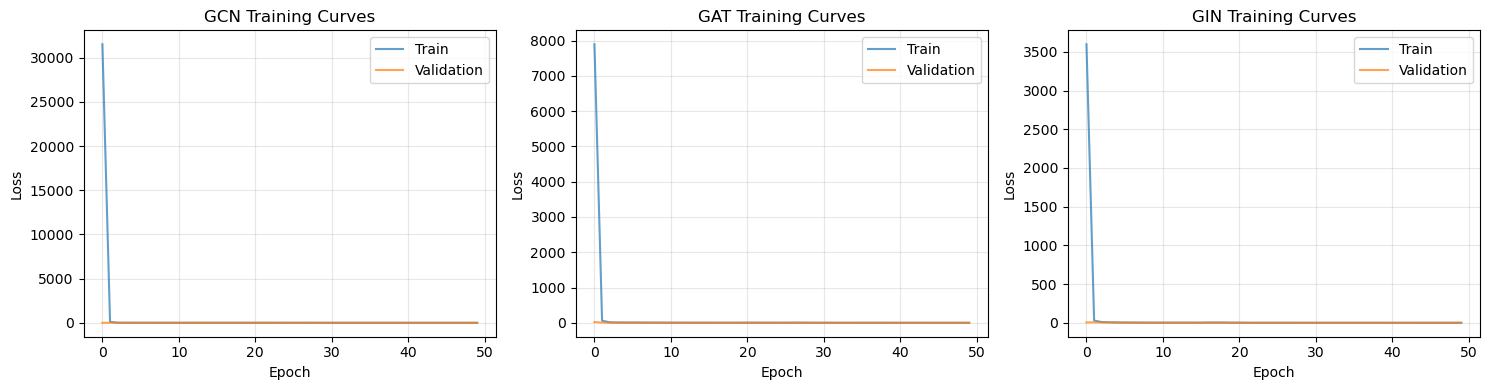

In [8]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (model_name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(res['train_losses'], label='Train', alpha=0.7)
    ax.plot(res['val_losses'], label='Validation', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name.upper()} Training Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Compare Model Performance


Model Performance Comparison:
         RMSE     MAE      R2  PEARSON  SPEARMAN
Model                                           
GCN    0.8986  0.6367  0.0241   0.3407    0.3427
GAT    0.8315  0.4936  0.1643   0.4699    0.4512
GIN    0.9061  0.5723  0.0077   0.4414    0.4454


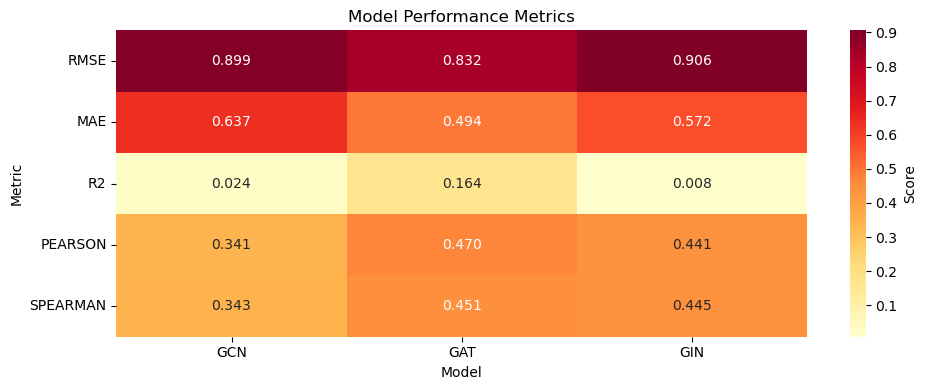

In [9]:
# Create comparison table
comparison_metrics = ['rmse', 'mae', 'r2', 'pearson', 'spearman']
comparison_data = []

for model_name, res in results.items():
    row = {'Model': model_name.upper()}
    for metric in comparison_metrics:
        row[metric.upper()] = res['test_metrics'][metric]
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Visualize as heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(comparison_df.T, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Score'})
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

## 10. Prediction Scatter Plots

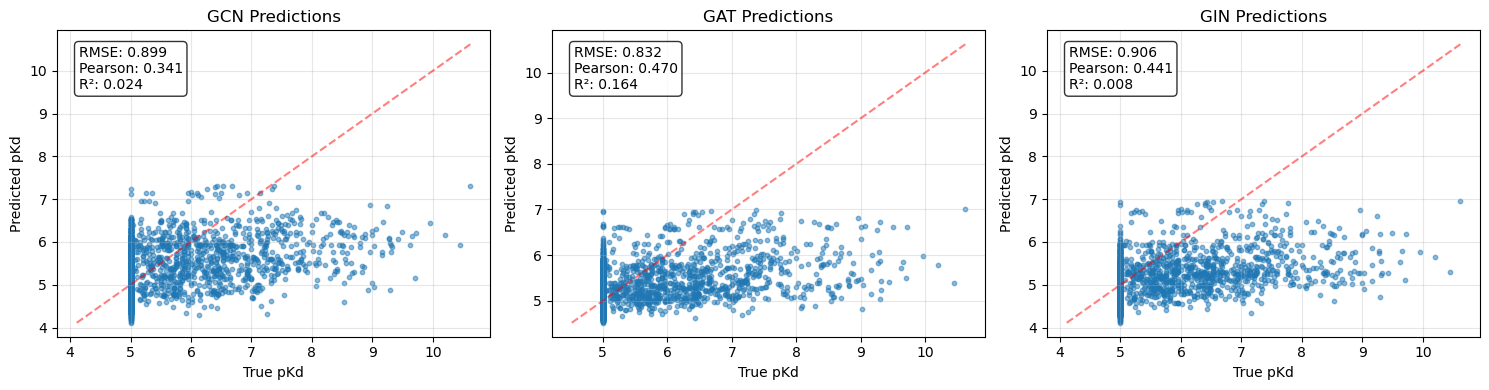

In [10]:
# Create scatter plots for each model
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (model_name, res) in enumerate(results.items()):
    ax = axes[i]
    
    # Get predictions and labels
    preds = res['test_preds']
    labels = res['test_labels']
    
    # Create scatter plot
    ax.scatter(labels, preds, alpha=0.5, s=10)
    
    # Add diagonal line
    min_val = min(labels.min(), preds.min())
    max_val = max(labels.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
    # Add metrics to plot
    metrics = res['test_metrics']
    text = f"RMSE: {metrics['rmse']:.3f}\nPearson: {metrics['pearson']:.3f}\nR²: {metrics['r2']:.3f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('True pKd')
    ax.set_ylabel('Predicted pKd')
    ax.set_title(f'{model_name.upper()} Predictions')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Save Results

In [11]:
# Save all results
results_file = MODEL_DIR / 'training_results.pkl'
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

# Save comparison table
comparison_df.to_csv(MODEL_DIR / 'model_comparison.csv')

print(f"✓ Results saved to {MODEL_DIR}")
print(f"  - Training results: training_results.pkl")
print(f"  - Model comparison: model_comparison.csv")
print(f"  - Model checkpoints: *_best.pt")

✓ Results saved to ../models/checkpoints
  - Training results: training_results.pkl
  - Model comparison: model_comparison.csv
  - Model checkpoints: *_best.pt


## 12. Summary

In [12]:
print("\n" + "="*50)
print("MODEL TRAINING COMPLETE")
print("="*50)

# Find best model
best_model = None
best_score = float('inf')

for model_name, res in results.items():
    rmse = res['test_metrics']['rmse']
    if rmse < best_score:
        best_score = rmse
        best_model = model_name

print(f"\nBest Model: {best_model.upper()}")
print(f"Test RMSE: {best_score:.4f}")
print(f"Test Pearson: {results[best_model]['test_metrics']['pearson']:.4f}")
print(f"Test R²: {results[best_model]['test_metrics']['r2']:.4f}")

print(f"\nModels trained on DAVIS dataset:")
print(f"  - {len(train_dataset)} training samples")
print(f"  - {len(val_dataset)} validation samples")
print(f"  - {len(test_dataset)} test samples")

print(f"\nNext steps:")
print(f"  1. Fine-tune hyperparameters")
print(f"  2. Train on KIBA dataset")
print(f"  3. Explore model interpretability (notebook 05)")


MODEL TRAINING COMPLETE

Best Model: GAT
Test RMSE: 0.8315
Test Pearson: 0.4699
Test R²: 0.1643

Models trained on DAVIS dataset:
  - 24044 training samples
  - 3005 validation samples
  - 3007 test samples

Next steps:
  1. Fine-tune hyperparameters
  2. Train on KIBA dataset
  3. Explore model interpretability (notebook 05)
